In [23]:
import joblib
from glob import glob
import warnings
import pandas as pd
import numpy as np
from random import choice
from datetime import datetime, timedelta
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from sklearn.metrics import (
    mean_squared_error,
    mean_squared_log_error,
    mean_absolute_error,
    r2_score,
)

dataset_period = [datetime.strptime('2013-07-01', '%Y-%m-%d'), datetime.strptime('2017-10-01', '%Y-%m-%d')]
test_period = [datetime.strptime('2017-10-01', '%Y-%m-%d') - timedelta(days=80), datetime.strptime('2017-10-01', '%Y-%m-%d')]
valid_period = [test_period[0] - timedelta(days=40), test_period[0]]
train_period = [dataset_period[0], valid_period[0]]
predict_time = "H"
sample_station = np.asarray([491,3002, 545, 412, 2000, 3409, 422, 3360, 3382, 3096, 3376, 3400, 3289, 275, 3413, 3329, 3421, 3053, 512, 2017])

output_notebook()
log_path = "logs/sarima"
warnings.filterwarnings("ignore")

Loading BokehJS ...

In [2]:
def caculate_loss(y_true, y_pred):
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)

    print("rmse:%f  rmsle:%f  mae:%f  corr:%f  r2:%f" % (rmse, rmsle, mae, corr, r2))

In [3]:
def draw_picture(df):
    df["y_pred"] = np.around(df["y_pred"].values)
    p = figure(
        plot_width=1000,
        plot_height=500,
        x_axis_type="datetime",
        x_axis_label="time",
        y_axis_label="flow",
    )
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"

    for column, color in zip(["y", "y_pred"], ["#FF0000", "#00BFFF"]):
        p.line(df.time, df[column], color=color, legend_label=column)
        p.circle(df.time, df[column], color=color, line_width=0.25, legend_label=column)

    p.legend.location = "top_right"
    p.legend.click_policy = "hide"
    show(p)

    p = figure(
        plot_width=1000, plot_height=500, x_axis_label="target", y_axis_label="predict",
    )
    p.xaxis.axis_label_text_font_size = "20pt"
    p.yaxis.axis_label_text_font_size = "20pt"

    p.circle(df.y, df.y_pred, line_width=0.25)
    show(p)

In [24]:
features = pd.read_hdf('process_data/features_201307_201709.h5', key='features')
station_info = pd.read_hdf("process_data/features_201307_201709.h5", key="info")
alive_df = pd.read_hdf("process_data/features_201307_201709.h5", key="alive")
alive_df = alive_df.query('@test_period[0] <= time < @test_period[1]')
predict_df = features[['time','stationid','y_in', 'y_out']].query('@test_period[0] <= time < @test_period[1] & @alive_df.is_alive == 1')

In [25]:
predicts_in = pd.concat([pd.read_csv(path, parse_dates=['time']) for path in glob(f"{log_path}/in/*")]).sort_values(['time', 'stationid'])
predicts_out = pd.concat([pd.read_csv(path, parse_dates=['time']) for path in glob(f"{log_path}/out/*")]).sort_values(['time', 'stationid'])

In [26]:
predict_df = predict_df.merge(predicts_in.drop(columns=['y_in']), how='left', on=['time', 'stationid']).rename(columns={'predict':'y_in_pred'})
predict_df = predict_df.merge(predicts_out.drop(columns=['y_out']), how='left', on=['time', 'stationid']).rename(columns={'predict':'y_out_pred'})

In [27]:
predict_df_in = (
    predict_df
    .rename(columns={"y_in_pred": "y_pred", "y_in": "y"})
)
predict_df_out = (
    predict_df
    .rename(columns={"y_out_pred": "y_pred", "y_out": "y"})
)

stationid_sort = predict_df.groupby('stationid')['y_in'].sum().sort_values(ascending=False).index

# Total Loss

In [ ]:
top_in = predict_df_in[predict_df_in.stationid.isin(sample_station)]
top_out = predict_df_out[predict_df_out.stationid.isin(sample_station)]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")

print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)

# Top 5 Loss

In [ ]:
top_in = predict_df_in[predict_df_in.stationid.isin(stationid_sort[:5])]
top_out = predict_df_out[predict_df_out.stationid.isin(stationid_sort[:5])]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")

print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)

# Top 10 Loss

In [ ]:
top_in = predict_df_in[predict_df_in.stationid.isin(stationid_sort[:10])]
top_out = predict_df_out[predict_df_out.stationid.isin(stationid_sort[:10])]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")

print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)

# 尖峰 Loss

In [ ]:
"""
先把y值為0數據拿掉，再以95百分為高峰門檻
"""
print("IN threashold:%i" % (predict_df_in.query("y > 0").y.quantile(0.95)))
print("OUT threashold:%i" % (predict_df_out.query("y > 0").y.quantile(0.95)))

In [ ]:
top_in = predict_df_in.query("y >= 20 & stationid in @sample_station")
top_out = predict_df_out.query("y >= 19  & stationid in @sample_station")
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)
print("\n")

print("OUT")
caculate_loss(top_out.y.values, top_out.y_pred.values)

# 場站預測流量圖

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [9]:
def draw_picture_plt(df, filename):
    df["y_pred"] = np.around(df["y_pred"].values)
    plt.figure(figsize=(25,10))
    
    plt.plot(df.time, df.y_pred, color='deepskyblue', linewidth=2, label='prediction')
    plt.scatter(df.time, df.y_pred, color='deepskyblue', linewidth=2)
    plt.plot(df.time, df.y, color='tomato', linewidth=2, label='obseration')
    plt.scatter(df.time, df.y, color='tomato', linewidth=2)
    
    plt.legend(prop={'size': 20})
    plt.xlabel("time", fontsize=25)
    plt.ylabel("flow", fontsize=25)
    plt.xticks(fontsize=15)
    plt.savefig(filename)
    plt.show()

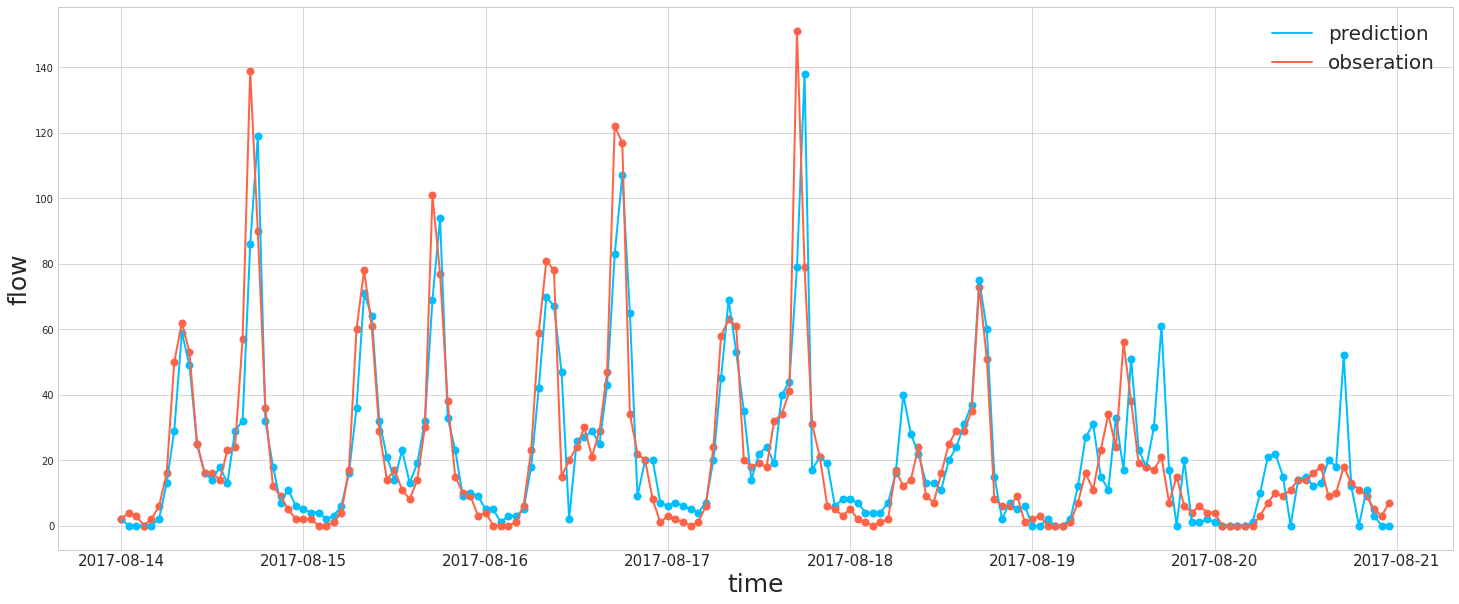

In [28]:
no = stationid_sort[0]
df = predict_df_in.query("stationid == @no")
df = df[(df.time >= datetime.strptime('2017-08-14', '%Y-%m-%d')) & (df.time < datetime.strptime('2017-08-21', '%Y-%m-%d'))]
draw_picture_plt(df, "SARIMA_normal")

In [ ]:
no = stationid_sort[0]
df = predict_df_in.query("stationid == @no")
caculate_loss(df.y.values, df.y_pred.values)
draw_picture(df)

df = predict_df_out.query("stationid == @no")
caculate_loss(df.y.values, df.y_pred.values)
draw_picture(df)

# 散點圖表示流量與loss

In [ ]:
def caculate_loss_df(df):
    y_true = df.y.values
    y_pred = df.y_pred.values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)

    return pd.DataFrame(
        {
            "sum_flow": df.y.sum(),
            "mean_flow": df.y.mean(),
            "median_flow": df.y.median(),
            "rmse": [rmse],
            "rmsle": [rmsle],
            "mae": [mae],
            "corr": [corr],
            "r2": [r2],
        }
    )

In [ ]:
def draw_loss_picture(df):
    for column in ["rmse", "rmsle", "mae", "corr", "r2"]:
        p = figure(
            plot_width=1000, plot_height=500, x_axis_label="flow", y_axis_label=column,
        )
        p.xaxis.axis_label_text_font_size = "20pt"
        p.yaxis.axis_label_text_font_size = "20pt"

        p.circle(df.flow, df[column], line_width=0.25)
        show(p)

In [ ]:
df = pd.concat(
    [
        predict_df_in.groupby("stationid").apply(caculate_loss_df).reset_index(level=0).set_index('stationid').add_prefix('in_'),
        predict_df_out.groupby("stationid").apply(caculate_loss_df).reset_index(level=0).set_index('stationid').add_prefix('out_')
    ],
    axis=1,
).sort_values('in_sum_flow', ascending=False)

In [ ]:
df.to_csv(f'{log_path}performance.csv')

# IN

In [ ]:
draw_loss_picture(
    predict_df_in.groupby("stationid").apply(caculate_loss_df).reset_index(level=0)
)

# OUT

In [ ]:
draw_loss_picture(
    predict_df_out.groupby("stationid").apply(caculate_loss_df).reset_index(level=0)
)

In [ ]:
top_in = predict_df_in[predict_df_in.stationid.isin(sample_station)]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)

# Top 5 Loss

In [ ]:
top_in = predict_df_in[predict_df_in.stationid.isin(stationid_sort[:5])]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)

# Top 10 Loss

In [ ]:
top_in = predict_df_in[predict_df_in.stationid.isin(stationid_sort[:10])]
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)

# 尖峰 Loss

In [ ]:
"""
先把y值為0數據拿掉，再以95百分為高峰門檻
"""
print("IN threashold:%i" % (predict_df_in.query("y > 0").y.quantile(0.95)))

In [ ]:
top_in = predict_df_in.query("y >= 20")
print("IN")
caculate_loss(top_in.y.values, top_in.y_pred.values)

# 場站預測流量圖

In [ ]:
no = stationid_sort[0]
df = predict_df_in.query("stationid == @no")
caculate_loss(df.y.values, df.y_pred.values)
draw_picture(df)

# 散點圖表示流量與loss

In [ ]:
def caculate_loss_df(df):
    y_true = df.y.values
    y_pred = df.y_pred.values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    rmsle = np.sqrt(mean_squared_log_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    corr = np.corrcoef(y_true, y_pred)[0, 1]
    r2 = r2_score(y_true, y_pred)

    return pd.DataFrame(
        {
            "sum_flow": df.y.sum(),
            "mean_flow": df.y.mean(),
            "median_flow": df.y.median(),
            "rmse": [rmse],
            "rmsle": [rmsle],
            "mae": [mae],
            "corr": [corr],
            "r2": [r2],
        }
    )

In [ ]:
def draw_loss_picture(df):
    for column in ["rmse", "rmsle", "mae", "corr", "r2"]:
        p = figure(
            plot_width=1000, plot_height=500, x_axis_label="flow", y_axis_label=column,
        )
        p.xaxis.axis_label_text_font_size = "20pt"
        p.yaxis.axis_label_text_font_size = "20pt"

        p.circle(df.flow, df[column], line_width=0.25)
        show(p)

In [ ]:
df = predict_df_in.groupby("stationid").apply(caculate_loss_df).reset_index(level=0).set_index('stationid').add_prefix('in_')

In [ ]:
df.to_csv(f'{log_path}/performance.csv')

# IN

In [ ]:
draw_loss_picture(
    predict_df_in.groupby("stationid").apply(caculate_loss_df).reset_index(level=0)
)

# OUT

In [ ]:
draw_loss_picture(
    predict_df_out.groupby("stationid").apply(caculate_loss_df).reset_index(level=0)
)